In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
import PIL
%matplotlib inline

In [3]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [4]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [5]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [6]:
print(training_ds)
print(testing_ds)

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>


In [7]:
class_names = training_ds.class_names

In [8]:
training_labels = training_ds.class_names
testing_labels = testing_ds.class_names

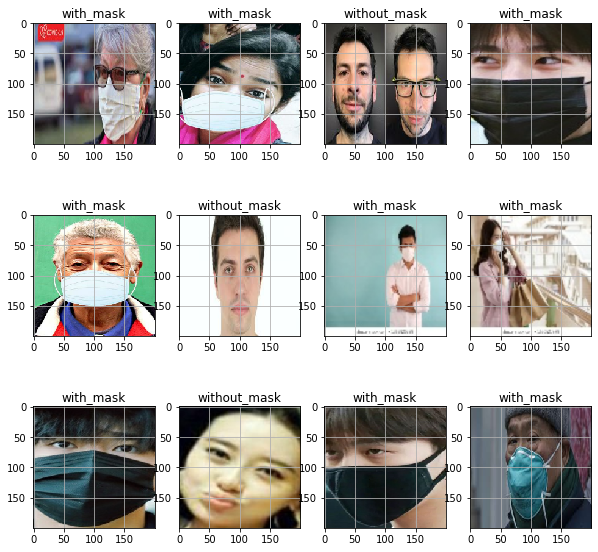

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [10]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

In [57]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = "sigmoid")
])

In [61]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])

In [62]:
history = model.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
152/152 [==============================] - 150s 987ms/step - loss: 0.4914 - accuracy: 0.7776 - recall_7: 0.8098 - precision_7: 0.7648 - val_loss: 0.2698 - val_accuracy: 0.8907 - val_recall_7: 0.8763 - val_precision_7: 0.9058
Epoch 2/10
152/152 [==============================] - 142s 933ms/step - loss: 0.2509 - accuracy: 0.8984 - recall_7: 0.8922 - precision_7: 0.9058 - val_loss: 0.2052 - val_accuracy: 0.9199 - val_recall_7: 0.9180 - val_precision_7: 0.9240
Epoch 3/10
152/152 [==============================] - 141s 926ms/step - loss: 0.1961 - accuracy: 0.9247 - recall_7: 0.9242 - precision_7: 0.9269 - val_loss: 0.2445 - val_accuracy: 0.9086 - val_recall_7: 0.9661 - val_precision_7: 0.8689
Epoch 4/10
152/152 [==============================] - 134s 882ms/step - loss: 0.1559 - accuracy: 0.9408 - recall_7: 0.9444 - precision_7: 0.9389 - val_loss: 0.2241 - val_accuracy: 0.9152 - val_recall_7: 0.9596 - val_precision_7: 0.8837
Epoch 5/10
152/152 [==============================] - 13

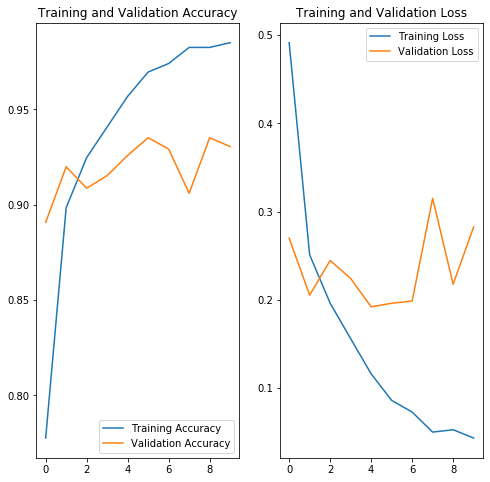

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
f1_train = (2*(0.9853*0.9850)/(0.9853+0.9850))
f1_test = (2*(0.9727*0.8989)/(0.9727+0.8989))

In [72]:
print(f1_train)
print(f1_test)

0.9851499771608384
0.9343449775593077


## Data Augmentation

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Dropout

In [12]:
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [13]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])

In [14]:
history2 = model2.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
152/152 [==============================] - 181s 1s/step - loss: 0.4392 - accuracy: 0.7940 - recall: 0.7781 - precision: 0.8079 - val_loss: 0.2636 - val_accuracy: 0.8954 - val_recall: 0.8711 - val_precision: 0.9190
Epoch 2/10
152/152 [==============================] - 169s 1s/step - loss: 0.2771 - accuracy: 0.8891 - recall: 0.8765 - precision: 0.9018 - val_loss: 0.2373 - val_accuracy: 0.9060 - val_recall: 0.8620 - val_precision: 0.9484
Epoch 3/10
152/152 [==============================] - 221s 1s/step - loss: 0.2547 - accuracy: 0.8938 - recall: 0.8833 - precision: 0.9046 - val_loss: 0.1985 - val_accuracy: 0.9152 - val_recall: 0.8672 - val_precision: 0.9624
Epoch 4/10
152/152 [==============================] - 207s 1s/step - loss: 0.2266 - accuracy: 0.9078 - recall: 0.8964 - precision: 0.9195 - val_loss: 0.1763 - val_accuracy: 0.9291 - val_recall: 0.9271 - val_precision: 0.9332
Epoch 5/10
152/152 [==============================] - 224s 1s/step - loss: 0.2108 - accuracy: 0.9184

In [41]:
ypred = model2.predict(testing_ds)
ypred = np.where(ypred > 0.5, 1, 0)

In [42]:
ytrue = [y for x, y in testing_ds]

In [43]:
ytrue = np.concatenate(ytrue)

In [47]:
from sklearn import metrics

print(metrics.confusion_matrix(ytrue, ypred))
print(metrics.classification_report(ytrue,ypred))

[[720  22]
 [ 57 711]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       742
           1       0.97      0.93      0.95       768

    accuracy                           0.95      1510
   macro avg       0.95      0.95      0.95      1510
weighted avg       0.95      0.95      0.95      1510



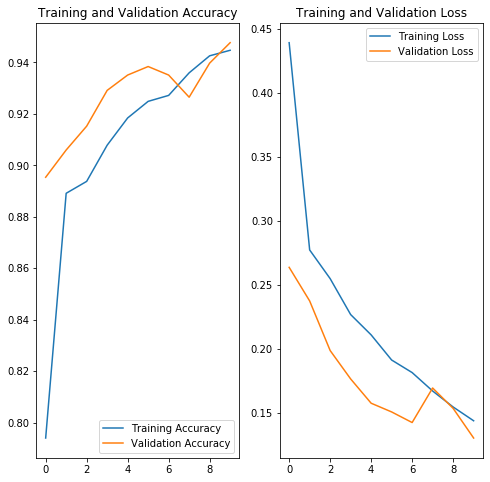

In [45]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()